## Generative Adverserial Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Define some parameters
batch_size = 48
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

datafolder = "/content/__MACOSX/symbols_dataset/"
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5),transforms.Grayscale()])
train_data = datasets.ImageFolder(root=datafolder, transform = transform)
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

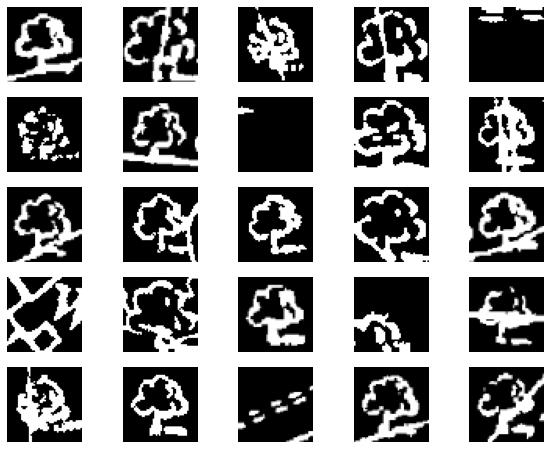

In [ ]:
images, labels = next(iter(dataloader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].squeeze(), cmap="gray")
plt.show()

In [ ]:
'''
The generator uses a relatively standard architecture and takes latent vector input Z of size 100 
and increases the size with ConvTranspose2d from 1 to 4 to 8 to 16 to 32 to 48
with the size of the feature maps going from 8*64 to 8*64 to halving to 4*64 to 2*64.
Batchnorm stabilizes the process and relu to prevent vanishing gradient problem.
'''

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z of size B x nz x 1 x 1, we put this directly into a transposed convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Size: B x (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size: B x (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size: B x (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, 1, 5, 3, 1, bias=False),
            # Size: B x 1 x 48 x 48
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)
netG.apply(weights_init)

from torchsummary import summary
summary(netG, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10            [-1, 1, 48, 48]           3,200
             Tanh-11            [-1, 1, 48, 48]               0
Total params: 3,445,632
Trainable params: 3,445,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [ ]:
'''
The discriminator has a standard structure with 4 convolutional layers which goes from size 48 to 24 to 8 to 4 to 1. 
Batchnorm layers between are used to stabilize training and leakyrelu layers to
prevent dying relu units which stops neurons from learning. Output is given 0 to 1 with sigmoid.
'''
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # state size. 1 x 48 x 48
            nn.Conv2d(1, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 3, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)
netD.apply(weights_init)


from torchsummary import summary
summary(netD, (1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 24, 24]           2,048
       BatchNorm2d-2          [-1, 128, 24, 24]             256
         LeakyReLU-3          [-1, 128, 24, 24]               0
            Conv2d-4            [-1, 256, 8, 8]         524,288
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]       1,048,576
       BatchNorm2d-8            [-1, 256, 4, 4]             512
         LeakyReLU-9            [-1, 256, 4, 4]               0
           Conv2d-10              [-1, 1, 1, 1]           4,096
          Sigmoid-11              [-1, 1, 1, 1]               0
Total params: 1,580,288
Trainable params: 1,580,288
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images,labels) in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_images = images.to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_images).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(z)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...
[1/50][0/350]	Loss_D: 1.8805	Loss_G: 1.7446	D(x): 0.2713	D(G(z)): 0.3097 / 0.2045
[1/50][50/350]	Loss_D: 0.2225	Loss_G: 6.7376	D(x): 0.9143	D(G(z)): 0.0789 / 0.0014
[1/50][100/350]	Loss_D: 0.1689	Loss_G: 8.0039	D(x): 0.8678	D(G(z)): 0.0025 / 0.0006
[1/50][150/350]	Loss_D: 0.1385	Loss_G: 4.8980	D(x): 0.9469	D(G(z)): 0.0729 / 0.0105
[1/50][200/350]	Loss_D: 0.2117	Loss_G: 6.5232	D(x): 0.9776	D(G(z)): 0.1453 / 0.0030
[1/50][250/350]	Loss_D: 0.0253	Loss_G: 6.3419	D(x): 0.9896	D(G(z)): 0.0144 / 0.0026
[1/50][300/350]	Loss_D: 0.1702	Loss_G: 9.9030	D(x): 0.9539	D(G(z)): 0.0921 / 0.0001
[2/50][0/350]	Loss_D: 0.1500	Loss_G: 3.9691	D(x): 0.9273	D(G(z)): 0.0656 / 0.0277
[2/50][50/350]	Loss_D: 0.0633	Loss_G: 4.2514	D(x): 0.9634	D(G(z)): 0.0214 / 0.0187
[2/50][100/350]	Loss_D: 0.0102	Loss_G: 7.1500	D(x): 0.9952	D(G(z)): 0.0052 / 0.0012
[2/50][150/350]	Loss_D: 0.0551	Loss_G: 5.9792	D(x): 0.9979	D(G(z)): 0.0472 / 0.0033
[2/50][200/350]	Loss_D: 0.0113	Loss_G: 5.8379	D(x): 0.99

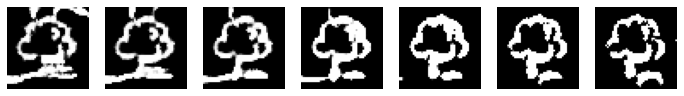

In [ ]:
# Solution

nsamples = 7
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)
for i in range(nsamples):
  w1 = i/(nsamples-1)
  w2 = 1-w1
  z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(12, 4))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].squeeze().cpu().detach(), cmap="gray")
plt.show()

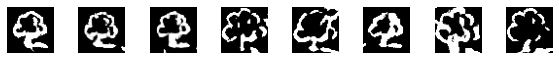

In [ ]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for label in range(1):
    z = torch.randn(8,nz,1,1,device=device)
    labels = torch.full((8,), label, dtype=torch.int, device=device)
    images = netG(z)
    for i in range(8):
        figure.add_subplot(10, 8, label*8+i+1)
        plt.axis("off")
        plt.imshow(0.5-0.5*images[i,:].cpu().detach().squeeze(), cmap="gray")
plt.show()